The Problem Statement: Embryo quality assessment is a critical aspect of assisted reproductive technology, aiding fertility specialists in selecting the most viable embryos for implantation. However, this process is both complex and subjective. In this competition, you're challenged to create a robust deep learning model capable of classifying embryos as 'good' or 'not good' based on their images at day-3 and day-5 of development.

The Dataset: Provided by Hung Vuong Hospital in Ho Chi Minh City, this dataset offers a unique observation into the early stages of embryo development. It comprises images of embryos at two crucial time points, day-3 and day-5. Each image is labeled as either 'good' or 'not good,' reflecting the embryo's potential for successful implantation.

Contribution:
- Subhiselvam A B 22BAD101, Animesh S 22BAD124 - Data Preprocessing
- Tarun V 22BAD103, Philip Winston Samuel 22BAD065 - Model Achitecture

Data link: https://www.kaggle.com/competitions/world-championship-2023-embryo-classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import cv2
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

The dataset is extracted from a zip file located in the Google Drive.

In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/split/world-championship-2023-embryo-classification.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

The training data (train.csv) is loaded and preprocessed.

In [4]:
# Path to the dataset
data_path = '/content/hvwc23/train/'
train_files = os.listdir(data_path)

# Load the train data
train_data = pd.read_csv('/content/hvwc23/train.csv')
train_data.head()

,Image,Class
0,D3_405.jpg,0
1,D3_523.jpg,0
2,D3_750.jpg,0
3,D3_427.jpg,0
4,D3_042.jpg,0


Images are read from the train/ folder, resized to 256x256, and stored in a list.

In [5]:
# Preprocess images
num_images = len(train_data['Image'])
train_images = []
image_names = list(train_data['Image'])

for image_name in image_names:
    img = cv2.imread(data_path + image_name, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)
    img = img.astype(np.uint8)
    train_images.append(img)

train_labels = train_data['Class'].to_list()

# Function to plot images
def plot_images(images):
    fig, axes = plt.subplots(1, 20, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

The data is imbalance 

Number of items in class 0: 716
Number of items in class 1: 124


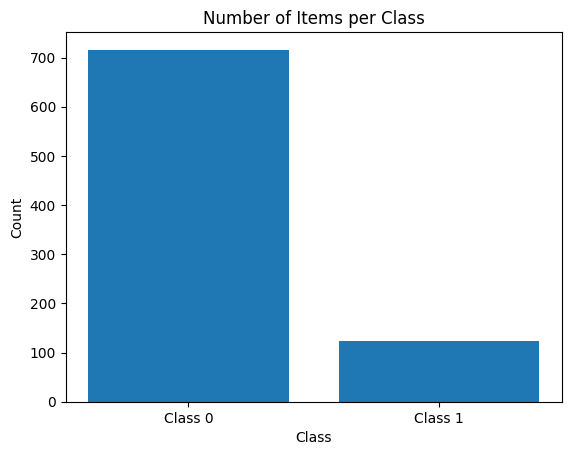

In [6]:
class_0_count = train_labels.count(0)
class_1_count = train_labels.count(1)

print("Number of items in class 0:", class_0_count)
print("Number of items in class 1:", class_1_count)

# Plot the counts
plt.bar(["Class 0", "Class 1"], [class_0_count, class_1_count])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Number of Items per Class")
plt.show()

Data augmentation is performed using techniques like rotation, shifting, shearing, zooming, and flipping to increase the dataset size.

In [7]:
# Data augmentation
augmentor = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest')
# Augment data
aug_images = []
aug_labels = []

for i in range(len(train_images)):
    image = np.expand_dims(train_images[i], 0)
    aug = augmentor.flow(image, batch_size=1)
    for j in range(5):  # Augment 5 times
        aug_img = next(aug)[0].astype(np.uint8)
        aug_images.append(aug_img)
        aug_labels.append(train_labels[i])

train_images = np.array(train_images + aug_images)
train_labels = np.array(train_labels + aug_labels)

The minority class is oversampled using the SMOTE technique to balance the dataset.

In [8]:
# Oversample minority class
oversampler = SMOTE()
num_rows = len(train_images)
train_images = train_images.reshape(num_rows, -1)
train_images, train_labels = oversampler.fit_resample(train_images, train_labels)
train_images = train_images.reshape(-1, 256, 256, 3)

The data is split into training and validation sets.

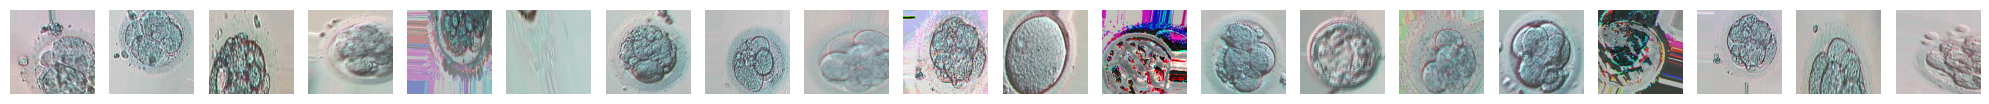

In [9]:
# Split data into train and validation sets
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, shuffle=True)


# Visualize some images
plot_images(x_train[0:20])

Now the datset has been balanced.

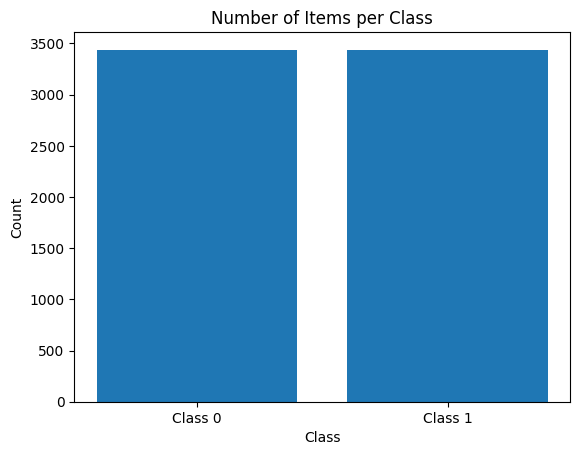

In [10]:
import matplotlib.pyplot as plt
import numpy as np
# Count the number of items in each class
class_0_count = np.count_nonzero(y_train == 0)
class_1_count = np.count_nonzero(y_train == 1)

# Plot the counts
plt.bar(["Class 0", "Class 1"], [class_0_count, class_1_count])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Number of Items per Class")
plt.show()


In [11]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(6873, 256, 256, 3)
(1719, 256, 256, 3)
(6873,)
(1719,)


In [12]:
# Hyperparameters
batch_size = 32
epochs = 50
img_height = 256
img_width = 256

A deep CNN model is defined using TensorFlow's Keras Sequential API.

In [13]:
# Create the model
model = Sequential([
    layers.Input((img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(1024, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(2048, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

The model is compiled with the Adam optimizer, binary cross-entropy loss, and accuracy metric.

In [14]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0

Callbacks are defined for early stopping and checkpointing the best model based on validation loss.

In [15]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)]

The model is trained on the training data for 50 epochs, with a batch size of 32.


In [16]:
# Train the model
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val),callbacks=callbacks)

Epoch 1/50
215/215 [==============================] - ETA: 0s - loss: 1.0034 - accuracy: 0.5248
Epoch 1: val_loss improved from inf to 0.56997, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


215/215 [==============================] - 64s 222ms/step - loss: 1.0034 - accuracy: 0.5248 - val_loss: 0.5700 - val_accuracy: 0.7696
Epoch 2/50
215/215 [==============================] - ETA: 0s - loss: 0.5814 - accuracy: 0.6264
Epoch 2: val_loss improved from 0.56997 to 0.49152, saving model to best_model.h5
215/215 [==============================] - 37s 174ms/step - loss: 0.5814 - accuracy: 0.6264 - val_loss: 0.4915 - val_accuracy: 0.7417
Epoch 3/50
215/215 [==============================] - ETA: 0s - loss: 0.4932 - accuracy: 0.7336
Epoch 3: val_loss improved from 0.49152 to 0.38708, saving model to best_model.h5
215/215 [==============================] - 44s 205ms/step - loss: 0.4932 - accuracy: 0.7336 - val_loss: 0.3871 - val_accuracy: 0.8232
Epoch 4/50
215/215 [==============================] - ETA: 0s - loss: 0.4538 - accuracy: 0.7886
Epoch 4: val_loss improved from 0.38708 to 0.36359, saving model to best_model.h5
215/215 [==============================] - 52s 243ms/step - loss

Training and validation accuracy and loss are plotted for each epoch.

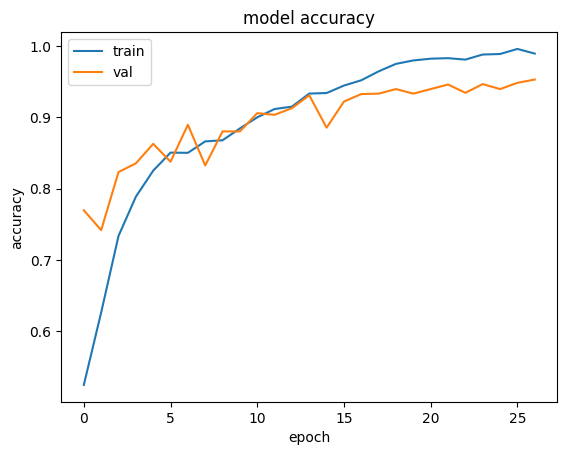

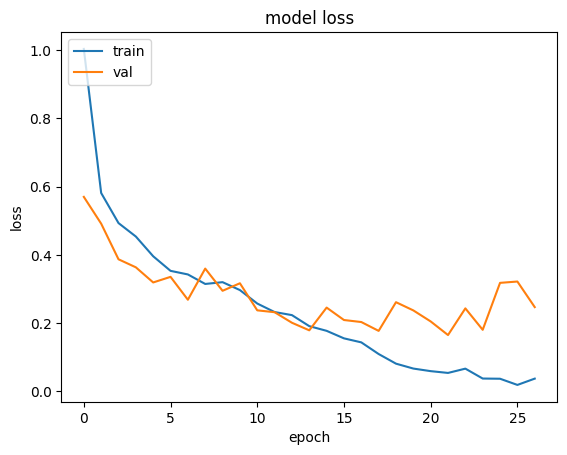

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


The best validation accuracy achieved during training is printed.

In [18]:
best_val_acc = max(history.history['val_accuracy'])
print('Best validation accuracy:', best_val_acc)

Best validation accuracy: 0.9528796076774597


The final trained model is saved to the Google Drive as final_model.h5.

In [20]:
# Save the final model
model.save('/content/drive/MyDrive/split/final_model.h5')